# Одноклассовая семантическая сегментация (штрихкоды)

[Данные](https://disk.yandex.ru/d/pRFNuxLQUZcDDg)

In [5]:
# Распакуем данные
!unzip "../data_segmentation.zip" -d "../"

Archive:  ../data_segmentation.zip
  inflating: ../data/README.md       
   creating: ../data/images/
  inflating: ../data/images/c16bbc1f-329e-4dc8-a7cf-bd4feb4e0d81--ru.bdd0ffd7-8f01-4265-b996-e2264735be45.jpg  
  inflating: ../data/images/d95e6dfd-2f83-4abe-a205-065c77eeccf0--ru.b34f84a2-83f9-42f4-9922-2714d6320550.jpg  
  inflating: ../data/images/a71eacf2-f1e9-4241-8820-b815cb545cb6--ru.92a0ffb2-e2d1-4aa8-b888-0d27f572ed83.jpg  
  inflating: ../data/images/dc9226c4-660a-4a02-a7c4-2fc1508549a4--ru.bc86f448-ec0d-4d86-a5e6-862b800f44c6.jpg  
  inflating: ../data/images/7a5ef483-4556-42be-9a22-db4df0cfda99--ru.c9907faf-afe9-4a35-b971-6b5702b7b9ab.jpg  
  inflating: ../data/images/92cdb08d-25ab-489f-ace4-68e11958d93b--ru.19fc5d60-ba81-49ef-b740-d78531814115.jpg  
  inflating: ../data/images/2af63b10-13ce-4507-baae-dab198d108bb--ru.5a2a5ae8-a63d-4522-b3e9-e1d875b8981a.jpg  
  inflating: ../data/images/0014c021-b5ec-40e1-86d9-8eb1e06da178--ru.fedd3d10-c498-455b-82d9-fe303c304d2f.jpg  
  

В папке `images` лежат собранные на Толоке фотографии со штрих-кодами.

В файле `annotations.tsv` лежит разметка этих изображений. В ней указаны:

- **filename** - относительный путь до изображения (вида images/<filename>), к которому относится аннотация.
- **code** - код штрих-кода, находящегося внутри ограничивающего бокса.
- **x_from** - минимальная координата ограничивающего бокса по оси x.
- **y_from** - минимальная координата ограничивающего бокса по оси y.
- **width** - ширина ограничивающего бокса.
- **height** - высота ограничивающего бокса.

Размеры изображений - варьируются

In [1]:
import pandas as pd
import numpy as np

import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import albumentations as albu
from  albumentations.pytorch.transforms import ToTensorV2
import lightning
# import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset, random_split
import torchmetrics

from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

import random

In [2]:
lightning.seed_everything(1)

Seed set to 1


1

## EDA

In [3]:
df = pd.read_csv('../data/annotations.tsv', sep='\t')

In [4]:
# df = df.drop('code', axis=1)
df.head()

filename           code  x_from  \
0  images/c234c76c-d72d-4d60-8066-e99f62361c1c--r...  4810153026194     210   
1  images/0b56af7e-386c-410a-8f46-74350f755d77--r...  8714100708408     216   
2  images/77c7bd8d-bb64-4c4b-94c5-798a903eaa4d--r...  4820240030508     173   
3  images/5d60b81b-e31d-4530-bed1-27a8872d1f02--r...  4607001770350      66   
4  images/bb225480-a447-4232-85ab-ce22f1dec070--r...  4605035006964     269   

   y_from  width  height  
0     542    279     143  
1     474    409     308  
2     657    589     293  
3     665    549     176  
4     592    448     247

In [5]:
df.shape

(540, 6)

In [6]:
# Create bbox xyxy instanse and split df to np.arrays
images_paths = df['filename'].values
images_bboxes = np.stack(
(
    df['x_from'].values,
    df['y_from'].values,
    df['x_from'].values + df['width'].values,
    df['y_from'].values + df['height'].values
),
    axis=-1,
    dtype=int
)

print(images_paths[0])
print(images_bboxes[0])

images/c234c76c-d72d-4d60-8066-e99f62361c1c--ru.a6a77966-14c1-49d8-bdd3-c9cbf12ae35d.jpg
[210 542 489 685]


In [7]:
image_shapes = []
for img_path in images_paths:
    image = cv2.imread('../data/'+img_path)
    shape = image.shape
    if shape not in image_shapes:
        image_shapes.append(shape)
        
print(image_shapes)

[(1333, 1000, 3), (1337, 1000, 3), (4160, 3120, 3), (1000, 1333, 3), (2000, 4000, 3), (4160, 2000, 3), (1778, 1000, 3), (3000, 4000, 3), (2220, 1000, 3), (1000, 1332, 3), (1000, 1000, 3), (4000, 2250, 3), (2169, 1000, 3), (3024, 4032, 3), (1331, 1000, 3), (4000, 3000, 3), (1080, 810, 3), (1836, 2448, 3), (1776, 1000, 3), (2058, 1000, 3), (1000, 2165, 3), (1332, 1000, 3), (4312, 5760, 3), (4032, 3024, 3), (1600, 1200, 3), (1024, 609, 3), (4032, 3016, 3), (2222, 1000, 3), (5760, 4312, 3), (1280, 960, 3), (1000, 1778, 3), (3840, 2160, 3), (4608, 3456, 3), (2165, 1000, 3), (1000, 2169, 3), (4000, 2000, 3), (1703, 1000, 3), (2174, 1000, 3), (480, 640, 3), (2448, 3264, 3)]


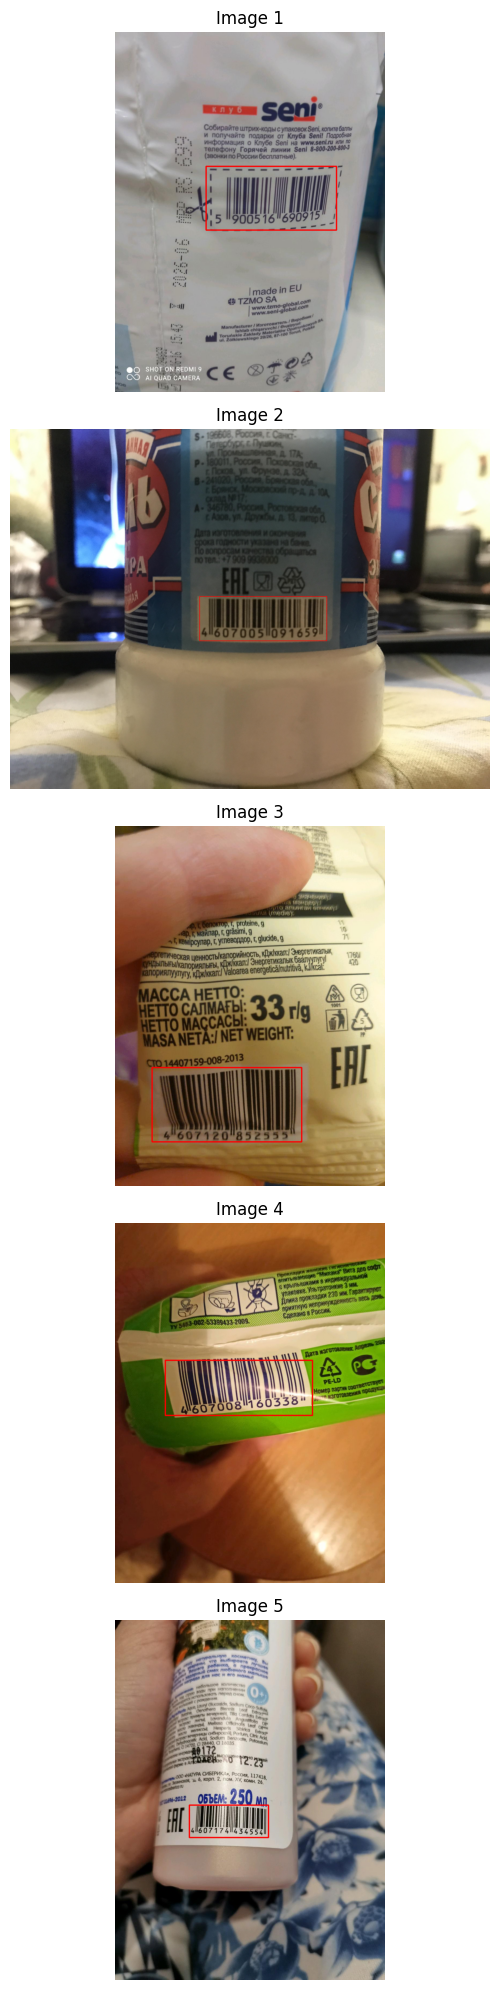

In [8]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i in range(5):
    random_i = random.randint(0, df.shape[0]-1)
    image_path = '../data/' + images_paths[random_i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # mask = np.zeros(image.shape[:2], dtype=np.uint8) 
    bbox_x1, bbox_y1, bbox_x2, bbox_y2 = images_bboxes[random_i]
    cv2.rectangle(
            image,
        (bbox_x1, bbox_y1),
        (bbox_x2, bbox_y2),
            255,
            3
        )

    axes[i].imshow(image)
    axes[i].set_title(f'Image {i + 1}')
    axes[i].axis('off')

    # axes[1, i].imshow(mask)
    # axes[1, i].set_title(f'Mask {i + 1}')
    # axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Create Dataset

In [20]:
# Split to test and validate
indices = np.random.permutation(images_paths.shape[0])
train_idx, validate_idx = indices[:90], indices[90:]
validate_paths, train_paths = images_paths[train_idx], images_paths[validate_idx]
validate_bboxes, train_bboxes = images_bboxes[train_idx], images_bboxes[validate_idx]

print(train_paths.shape, validate_paths.shape)
print(train_bboxes.shape, validate_bboxes.shape)

(450,) (90,)
(450, 4) (90, 4)


In [21]:
from typing import Optional, Tuple
from numpy.typing import NDArray
from torch import Tensor

class SegDataset(Dataset):
    CLASSES = ['barcode']
    def __init__(
            self, 
            image_dir: str, 
            image_paths: np.array,
            image_bboxes: np.array,
            classes: Optional[list]=None,             
            transforms: Optional[albu.BaseCompose]=None,
            preprocessing: Optional[albu.BaseCompose]=None,
    ):
        self.image_dir = image_dir
        self.image_paths = image_paths
        self.image_bboxes = image_bboxes
        self.classes = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, idx: int) -> Tuple:
        img_path = os.path.join(
            self.image_dir, 
            self.image_paths[idx]
        )
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.zeros(image.shape[:2], dtype=np.uint8) 
        bbox_x1, bbox_y1, bbox_x2, bbox_y2 = self.image_bboxes[idx]
        cv2.rectangle(
                mask,
            (bbox_x1, bbox_y1),
            (bbox_x2, bbox_y2),
                1,
                -1
            )
        # 
        # # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        mask = np.stack([mask], axis=-1).astype('float')

        if self.transforms is not None:
            out = self.transforms(
                image=image,
                mask=mask
            )
            image = out["image"]
            mask = out["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

In [22]:
# Set transformation fot test and validate
transform_train = albu.Compose(
    [
        # albu.RandomResizedCrop (
        #     height=256, 
        #     width=256, 
        #     scale=(0.9, 1.1), 
        #     ratio=(1, 1),
        #     interpolation=cv2.INTER_LINEAR, 
        #     p=1
        # ),
        albu.Resize(width=512, height=512, p=1),
        albu.MotionBlur(blur_limit=5, p=0.5),
        # albu.ColorJitter(
        #     brightness=0.2, 
        #     contrast=0.2, 
        #     saturation=0.2, 
        #     hue=0.2, 
        #     always_apply=False, 
        #     p=0.5
        # ),
        albu.GaussianBlur(
            blur_limit=(3, 7), 
            sigma_limit=0, 
            always_apply=False, 
            p=0.5
        ),
        # albu.HueSaturationValue(
        #     hue_shift_limit=20, 
        #     sat_shift_limit=30, 
        #     val_shift_limit=20, 
        #     always_apply=False, 
        #     p=0.5
        # ),
        albu.Flip()
    ]
)

transform_validate = albu.Compose(
    [
        albu.Resize(width=512, height=512, p=1),
        # albu.Normalize(
        #             mean=(0.485, 0.456, 0.406),
        #             std=(0.229, 0.224, 0.225),
        #             max_pixel_value=255.0,
        #             always_apply=False,
        #             p=1.0
        #         ),
        # ToTensorV2()
    ]
)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def dummy_preprocessing():
    return albu.Compose(
        [
            albu.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0,
                    always_apply=False,
                    p=1.0
                ),
            albu.Lambda(image=to_tensor, mask=to_tensor),
        ]
    )

from torch import Tensor

def denormalize(
    img: NDArray[float],
    mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
    std: Tuple[float, ...] = (0.229, 0.224, 0.225),
    max_value: int = 255,
) -> NDArray[int]:
    denorm = albu.Normalize(
        mean=[-me / st for me, st in zip(mean, std)],  # noqa: WPS221
        std=[1.0 / st for st in std],
        always_apply=True,
        max_pixel_value=1.0,
    )
    denorm_img = denorm(image=img)['image'] * max_value
    return denorm_img.astype(np.uint8)

def tensor_to_cv_image(tensor: Tensor) -> NDArray[float]:
    return tensor.permute(1, 2, 0).cpu().numpy()

## Load and evaluate NN, torch

In [33]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['barcode']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/dmitriy/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:13<00:00, 7.61MB/s]


In [34]:
train_dataset = SegDataset(
        image_dir = '../data/', 
        image_paths = train_paths,
        image_bboxes = train_bboxes,
        classes=['barcode'],
        transforms = transform_train,
        preprocessing = get_preprocessing(preprocessing_fn)
    )
validate_dataset = SegDataset(
        image_dir = '../data/', 
        image_paths = validate_paths,
        image_bboxes = validate_bboxes,
        classes=['barcode'],
        transforms = transform_validate,
        preprocessing = get_preprocessing(preprocessing_fn)
    )

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(validate_dataset, batch_size=1, shuffle=False, num_workers=4)

Selected index 284 from 450. Image: images/3c0f8279-5929-4046-a837-dbc6d41b18e1--ru.700d52c7-a754-46a3-a75c-34b03f072180.jpg

Selected index 54 from 90. Image: images/69d5d790-de13-421f-b48b-65cd8004a079--ru.2202f665-13b3-4e08-af7a-be267fef7f2a.jpg


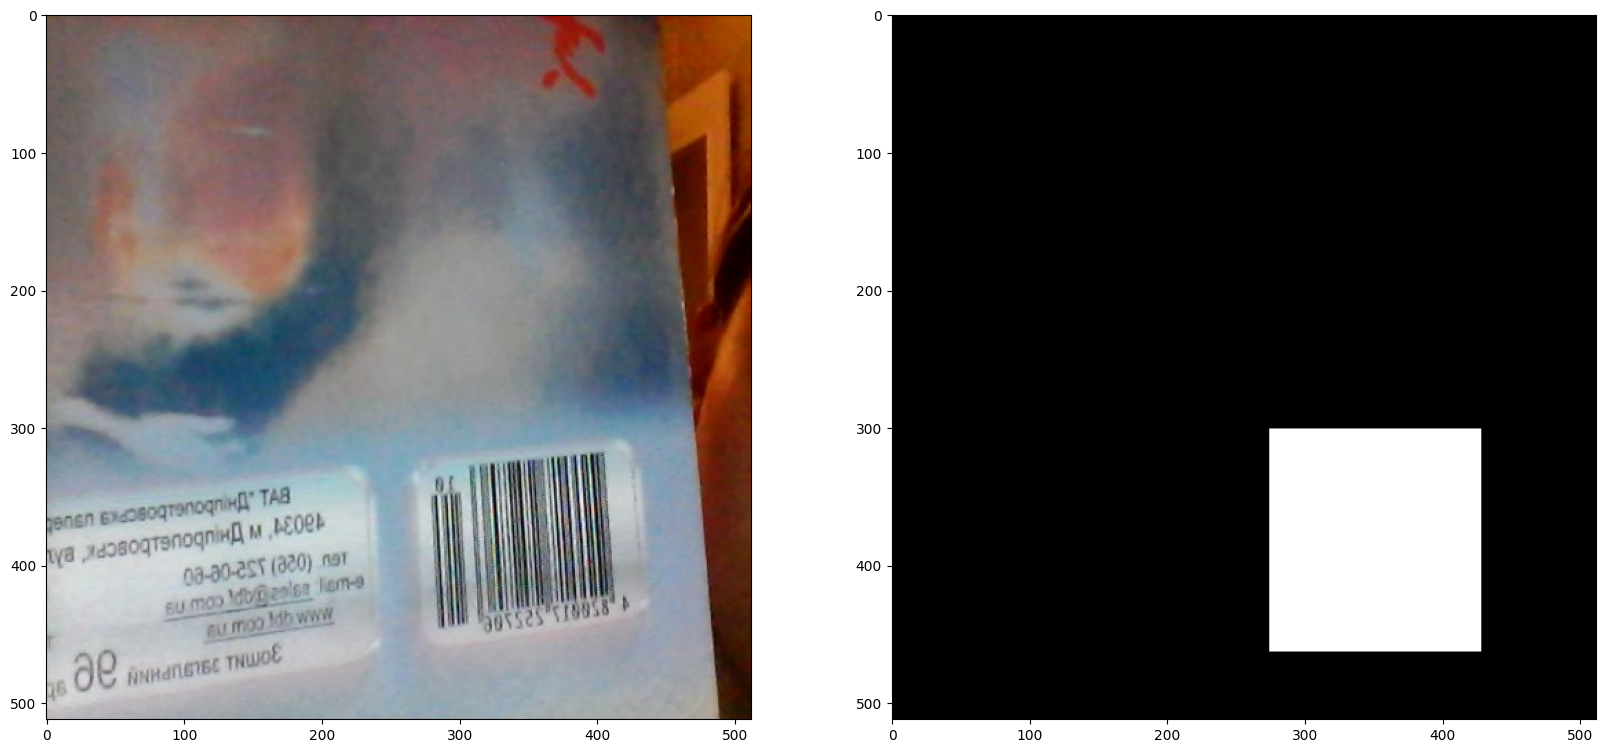

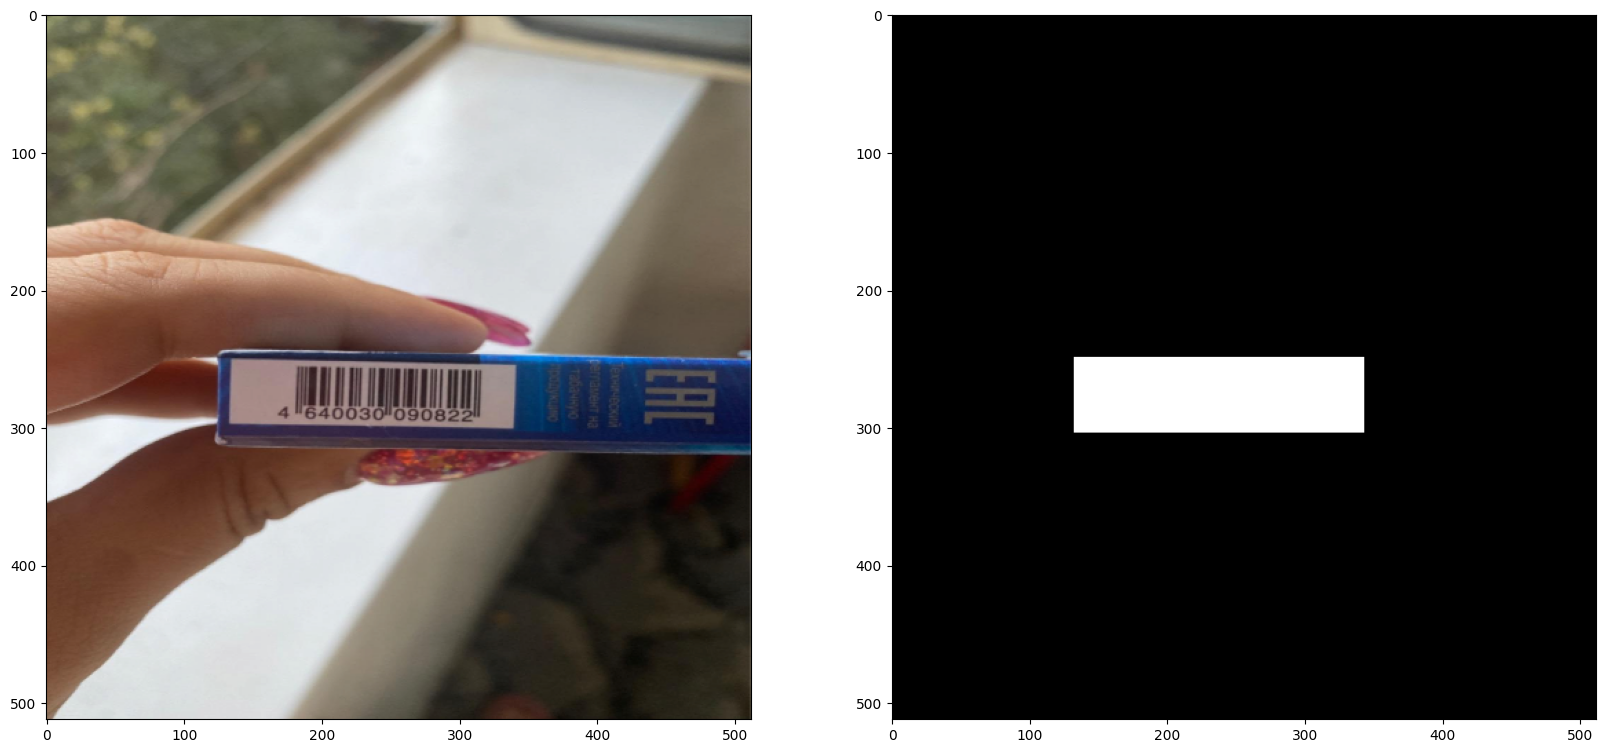

In [35]:
# Test dataset
import random
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

for _test_dataset in [train_dataset, validate_dataset]:
    random_i = random.randint(0, _test_dataset.__len__() - 1)
    print(
        f"Selected index {random_i} from {_test_dataset.__len__()}. Image: {_test_dataset.image_paths[random_i]}"
    )
    test_image, test_mask = _test_dataset[random_i]
    
    test_image = np.transpose(test_image, (1,2,0))
    test_image = denormalize(test_image)
    test_image = test_image.astype(np.uint8)
    
    test_mask = np.transpose(test_mask, (1,2,0))
    
    plt.rcParams['figure.figsize'] = [20, 10]
    f, axarr = plt.subplots(1, 2) 
    
    axarr[0].imshow(test_image, cmap='gray', vmin=0, vmax=255)
    axarr[1].imshow(test_mask, cmap='gray', vmin=0, vmax=1)
    print()

process

process


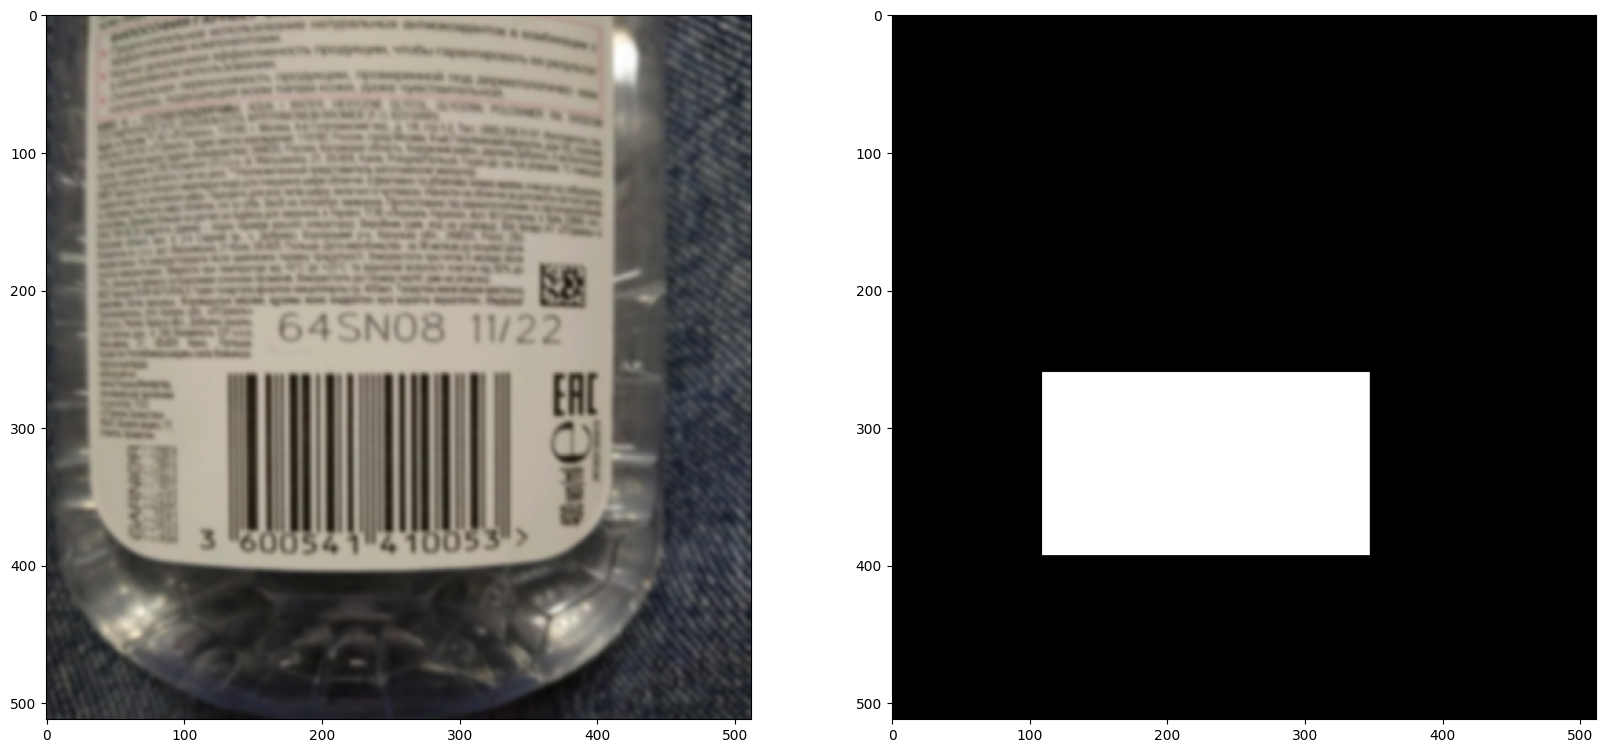

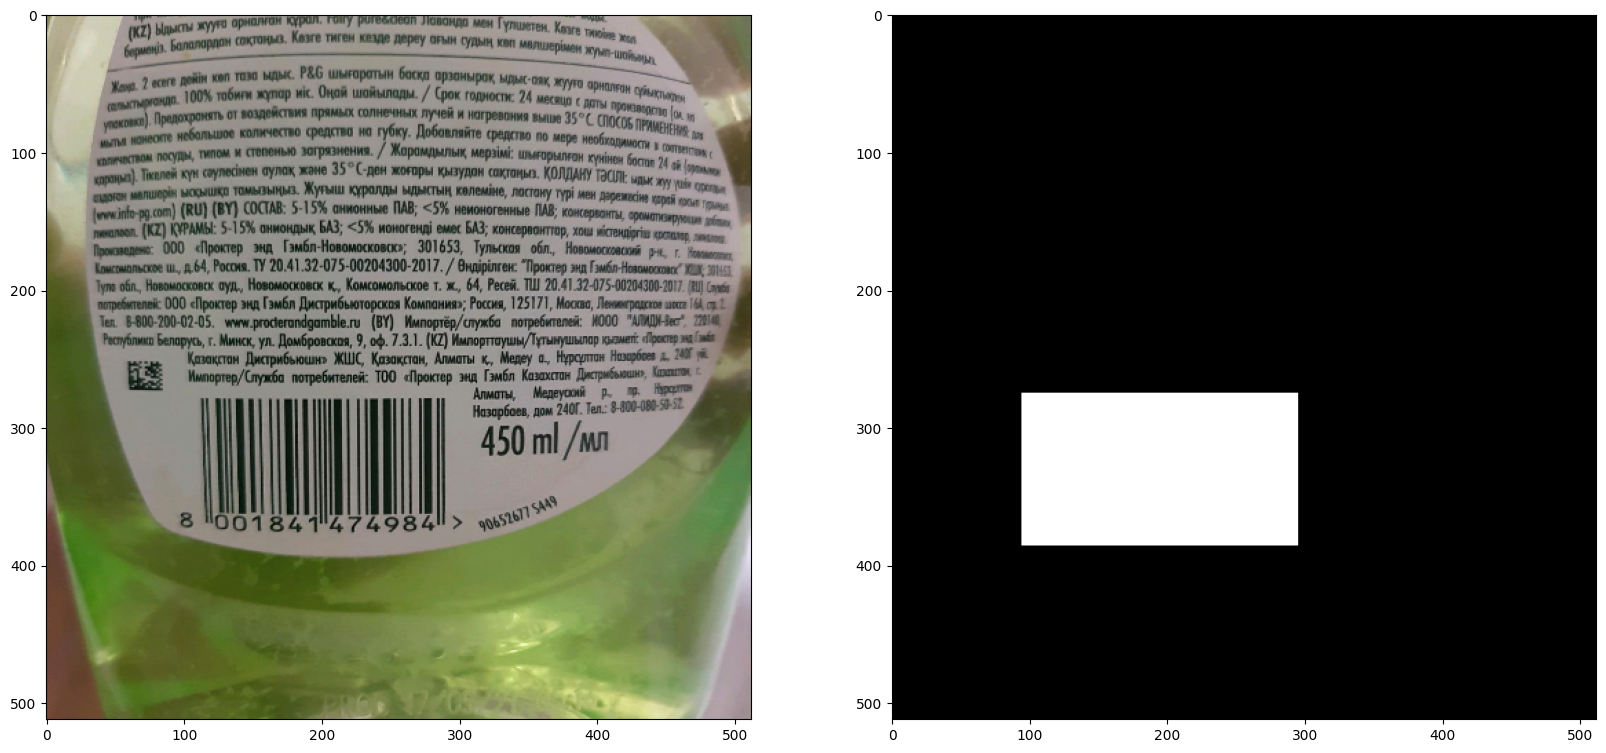

In [36]:
# Test dataloader
for _test_dataloader in [train_loader, valid_loader]:
    print('process')
    test_image, test_mask = next(iter(_test_dataloader))
    test_image = np.transpose(test_image[0], (1,2,0))
    test_image = denormalize(test_image.numpy())
    test_image = test_image.astype(np.uint8)
    
    test_mask = np.transpose(test_mask[0], (1,2,0))
    
    plt.rcParams['figure.figsize'] = [20, 10]
    f, axarr = plt.subplots(1, 2) 
    
    axarr[0].imshow(test_image, cmap='gray', vmin=0, vmax=255)
    axarr[1].imshow(test_mask, cmap='gray', vmin=0, vmax=1)
    print()

In [37]:
import segmentation_models_pytorch.utils
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [38]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [39]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 90/90 [00:03<00:00, 27.79it/s, dice_loss - 0.1334, iou_score - 0.7788]
Model saved!

Epoch: 1
valid: 100%|██████████| 90/90 [00:03<00:00, 27.93it/s, dice_loss - 0.1181, iou_score - 0.8028]
Model saved!

Epoch: 2
valid: 100%|██████████| 90/90 [00:03<00:00, 27.92it/s, dice_loss - 0.1046, iou_score - 0.8269]
Model saved!

Epoch: 3
valid: 100%|██████████| 90/90 [00:03<00:00, 28.17it/s, dice_loss - 0.1066, iou_score - 0.823] 

Epoch: 4
valid: 100%|██████████| 90/90 [00:03<00:00, 27.79it/s, dice_loss - 0.09082, iou_score - 0.844] 
Model saved!

Epoch: 5
valid: 100%|██████████| 90/90 [00:03<00:00, 27.85it/s, dice_loss - 0.09844, iou_score - 0.8359]

Epoch: 6
valid: 100%|██████████| 90/90 [00:03<00:00, 27.70it/s, dice_loss - 0.08816, iou_score - 0.8509]
Model saved!

Epoch: 7
valid: 100%|██████████| 90/90 [00:03<00:00, 28.12it/s, dice_loss - 0.08975, iou_score - 0.8516]
Model saved!

Epoch: 8
valid: 100%|██████████| 90/90 [00:03<00:00, 28.31it/s, dice_loss - 0

## Inference

In [41]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [54]:
# create test dataset
test_dataset = SegDataset(
        image_dir = '../data/', 
        image_paths = validate_paths,
        image_bboxes = validate_bboxes,
        classes=['barcode'],
        transforms = transform_validate,
        preprocessing = get_preprocessing(preprocessing_fn)
    )

test_dataloader = DataLoader(validate_dataset)

In [55]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 90/90 [00:04<00:00, 18.88it/s, dice_loss - 0.08123, iou_score - 0.8661]


Selected index 30 from 90. Image: images/cd5be268-97e2-4c6f-8462-99e3bba1638e--ru.d39fcd2d-9b54-4f56-bd0d-9e9c6c018f9e.jpg
Selected index 23 from 90. Image: images/cc6f89b8-edb4-4aa8-b2b0-cda54befc00c--ru.f0db284c-a453-4553-b500-3d7a2463f59d.jpg
Selected index 50 from 90. Image: images/aefae2f8-afa4-4bfd-b509-97c7f99aa22d--ru.3f83b35d-6dee-4d54-818c-cdb9b1d55741.jpg
Selected index 21 from 90. Image: images/3811eb7e-bb36-40ab-b42b-616ede97dbc1--ru.949d75d9-898e-4b5d-a498-622ec0145c83.jpg
Selected index 71 from 90. Image: images/ff8c167e-0909-48a3-9a17-419d75109699--ru.1e9c4d27-04a7-4869-913b-e659f86949c6.jpg


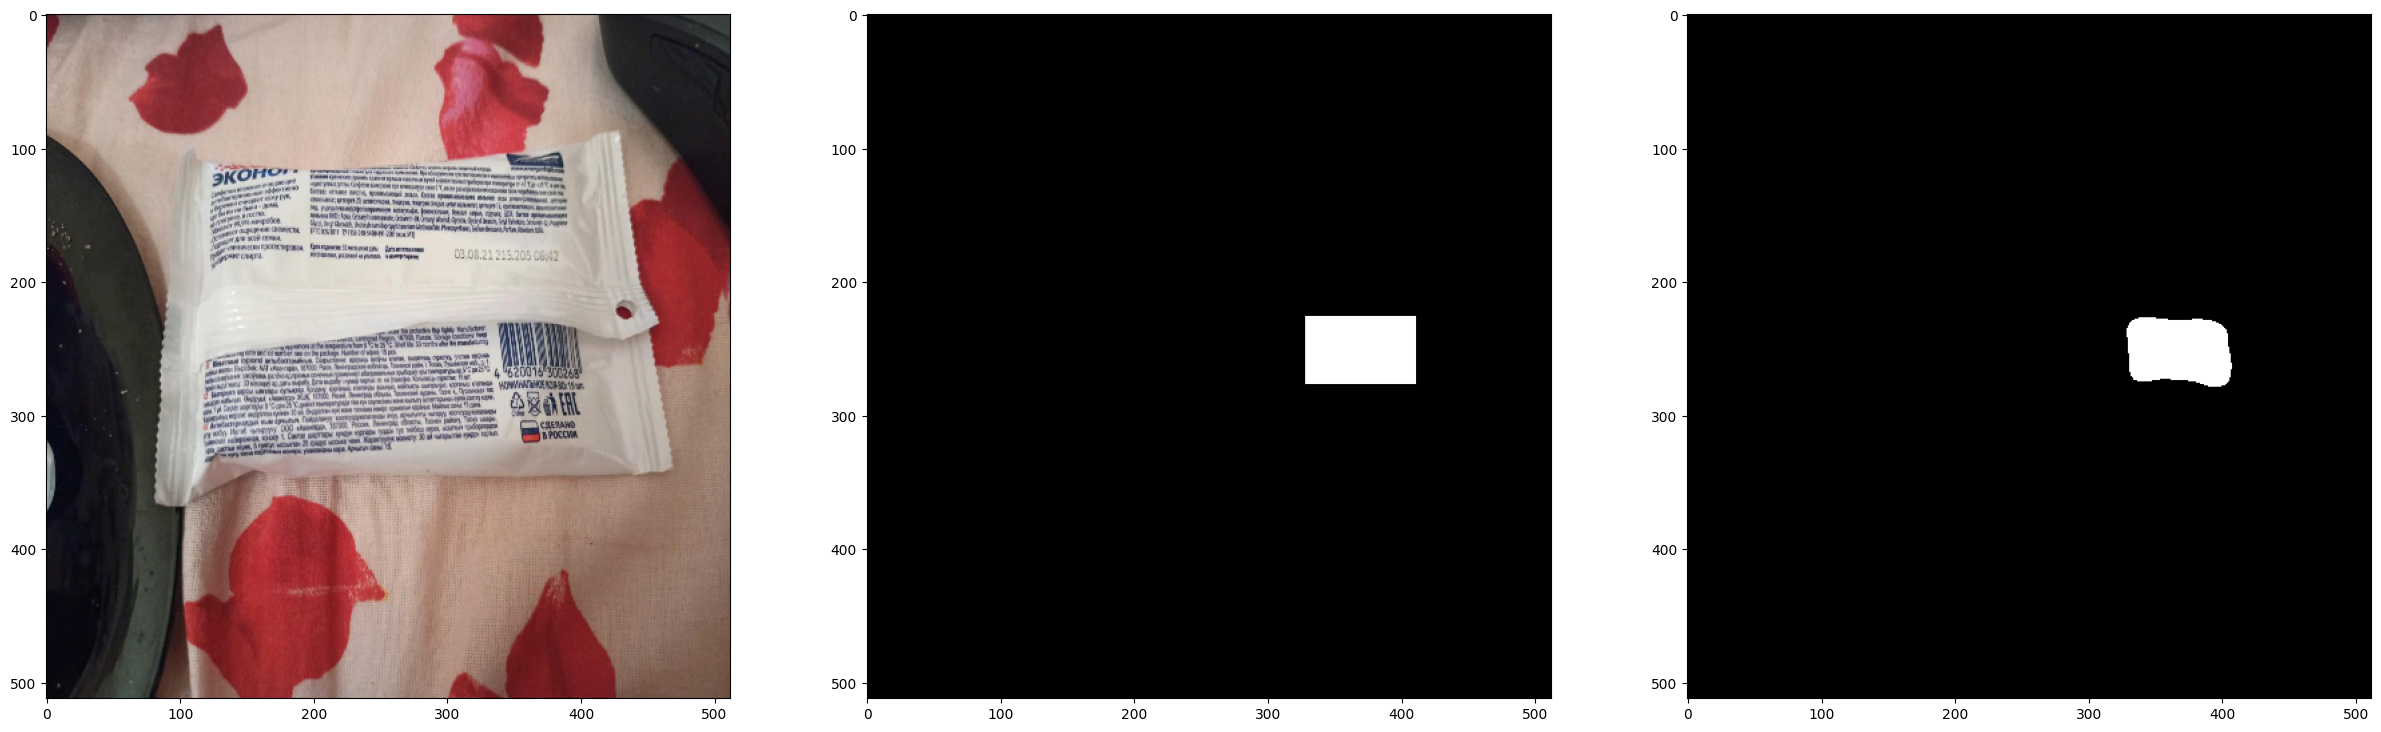

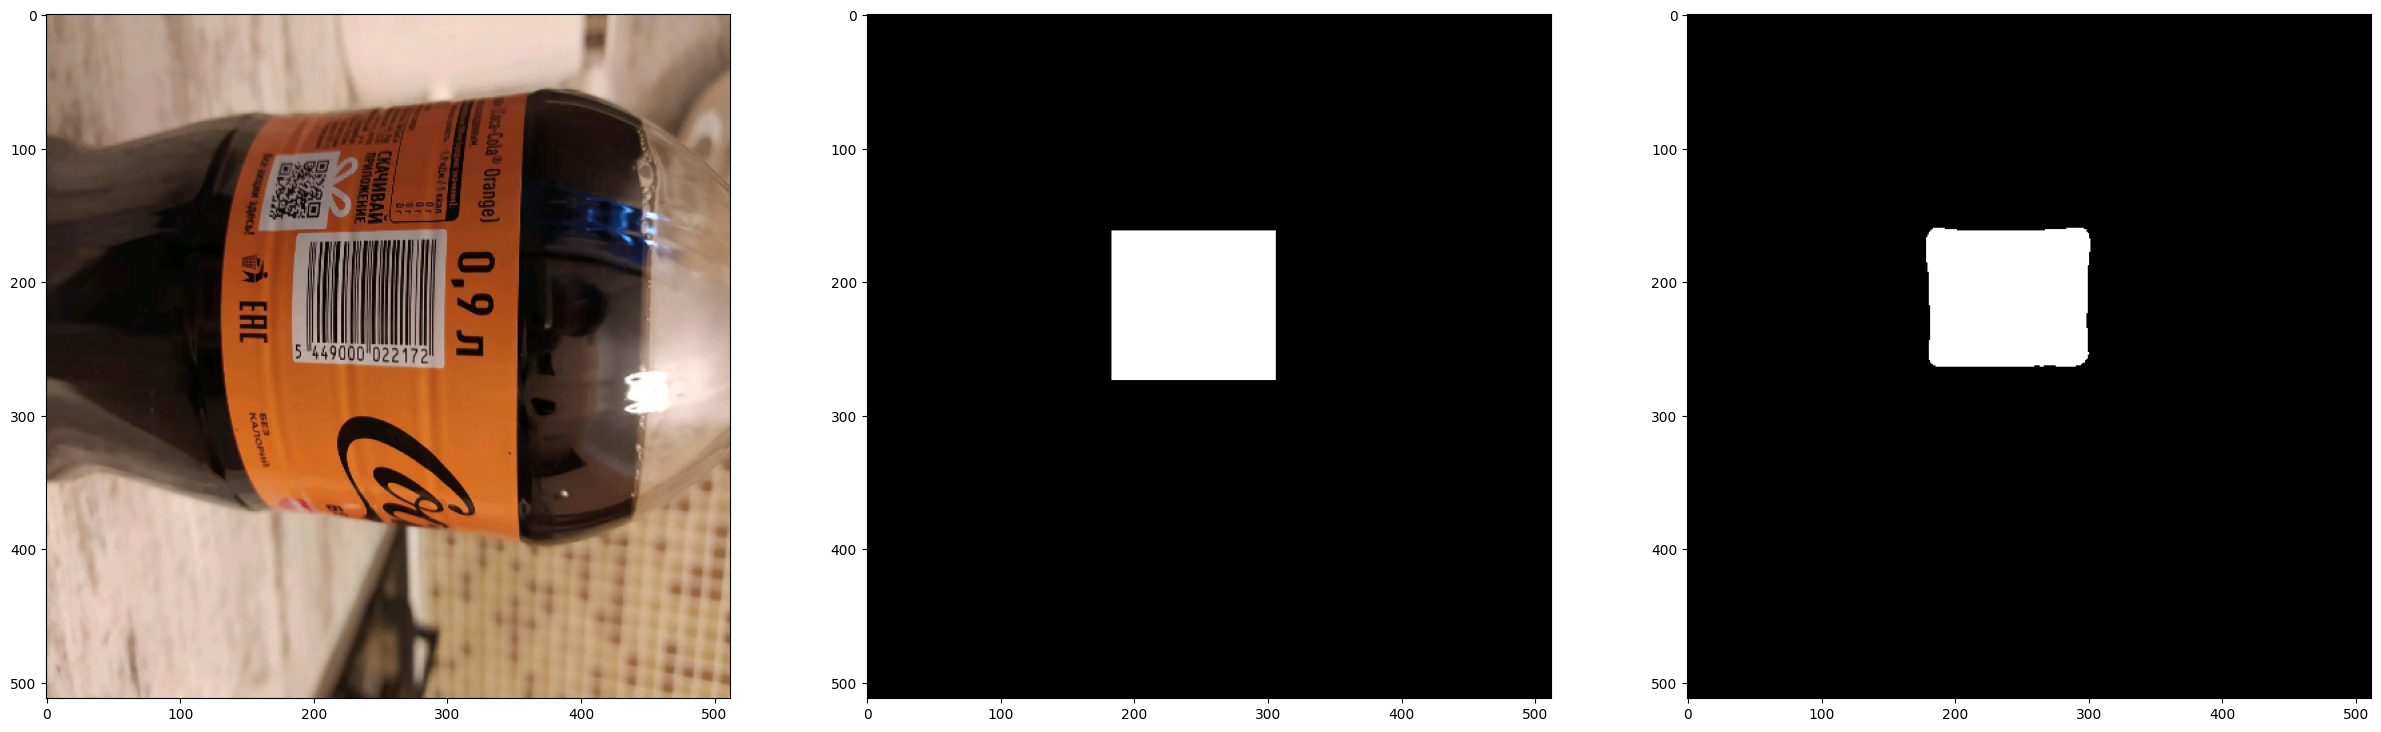

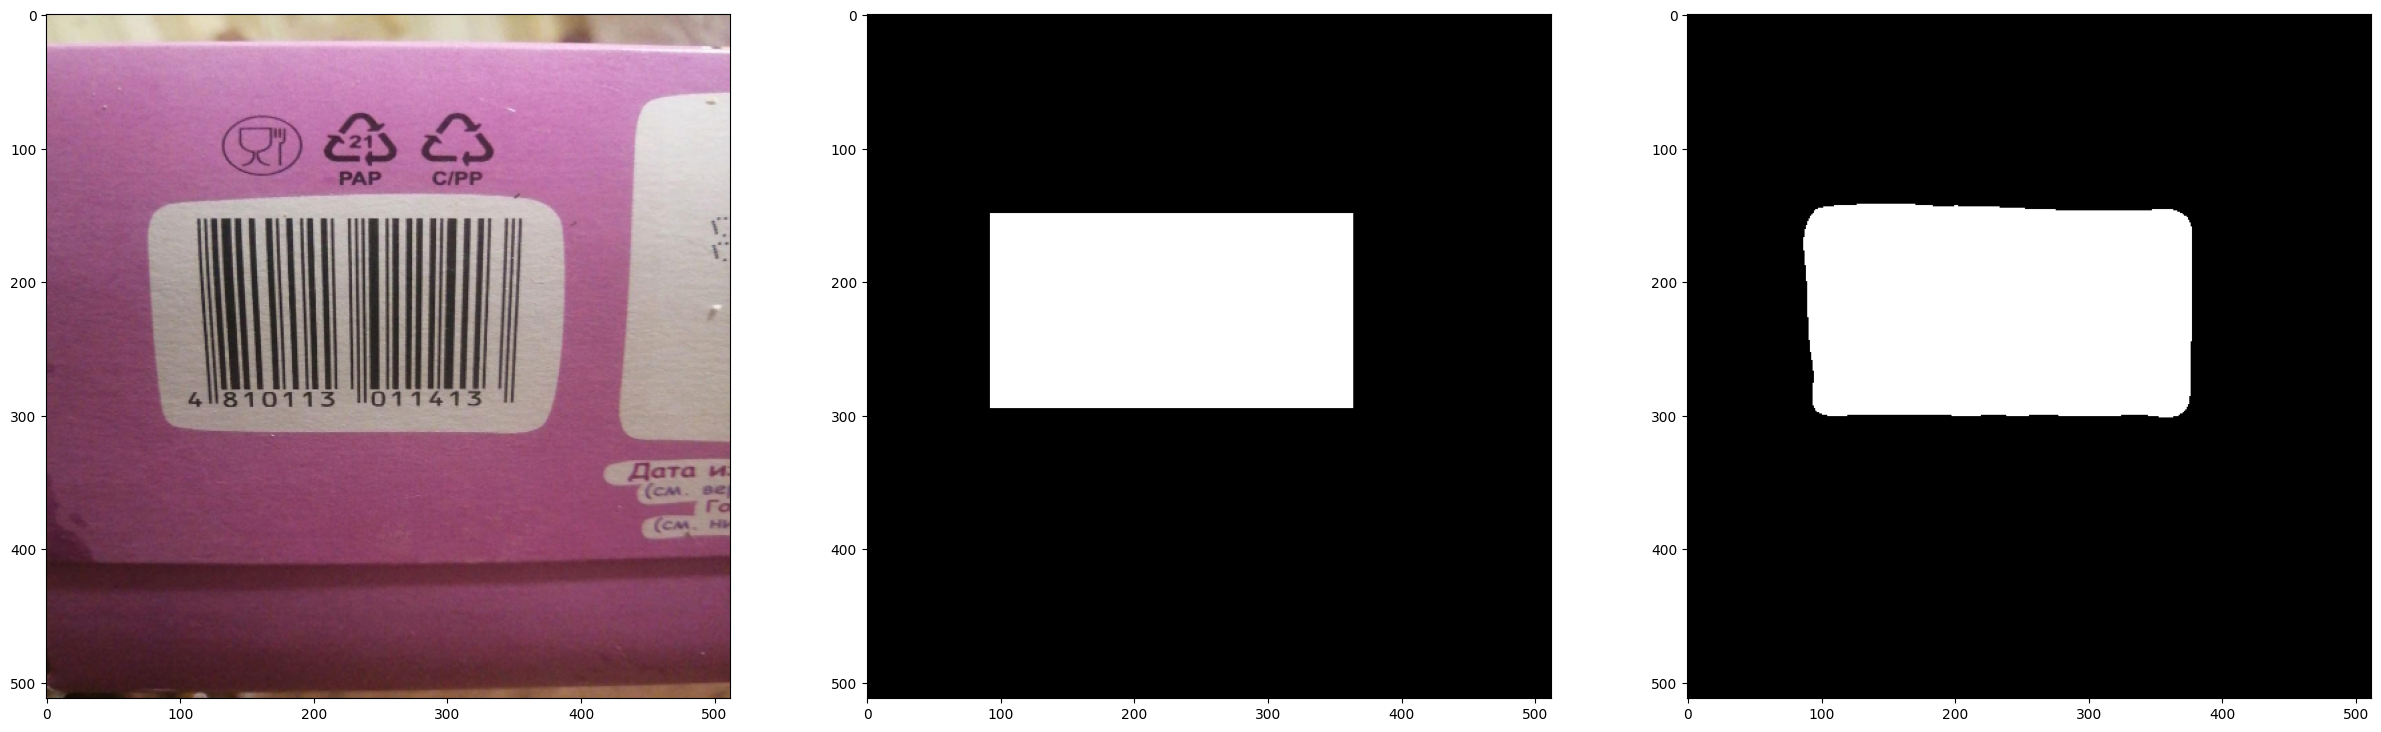

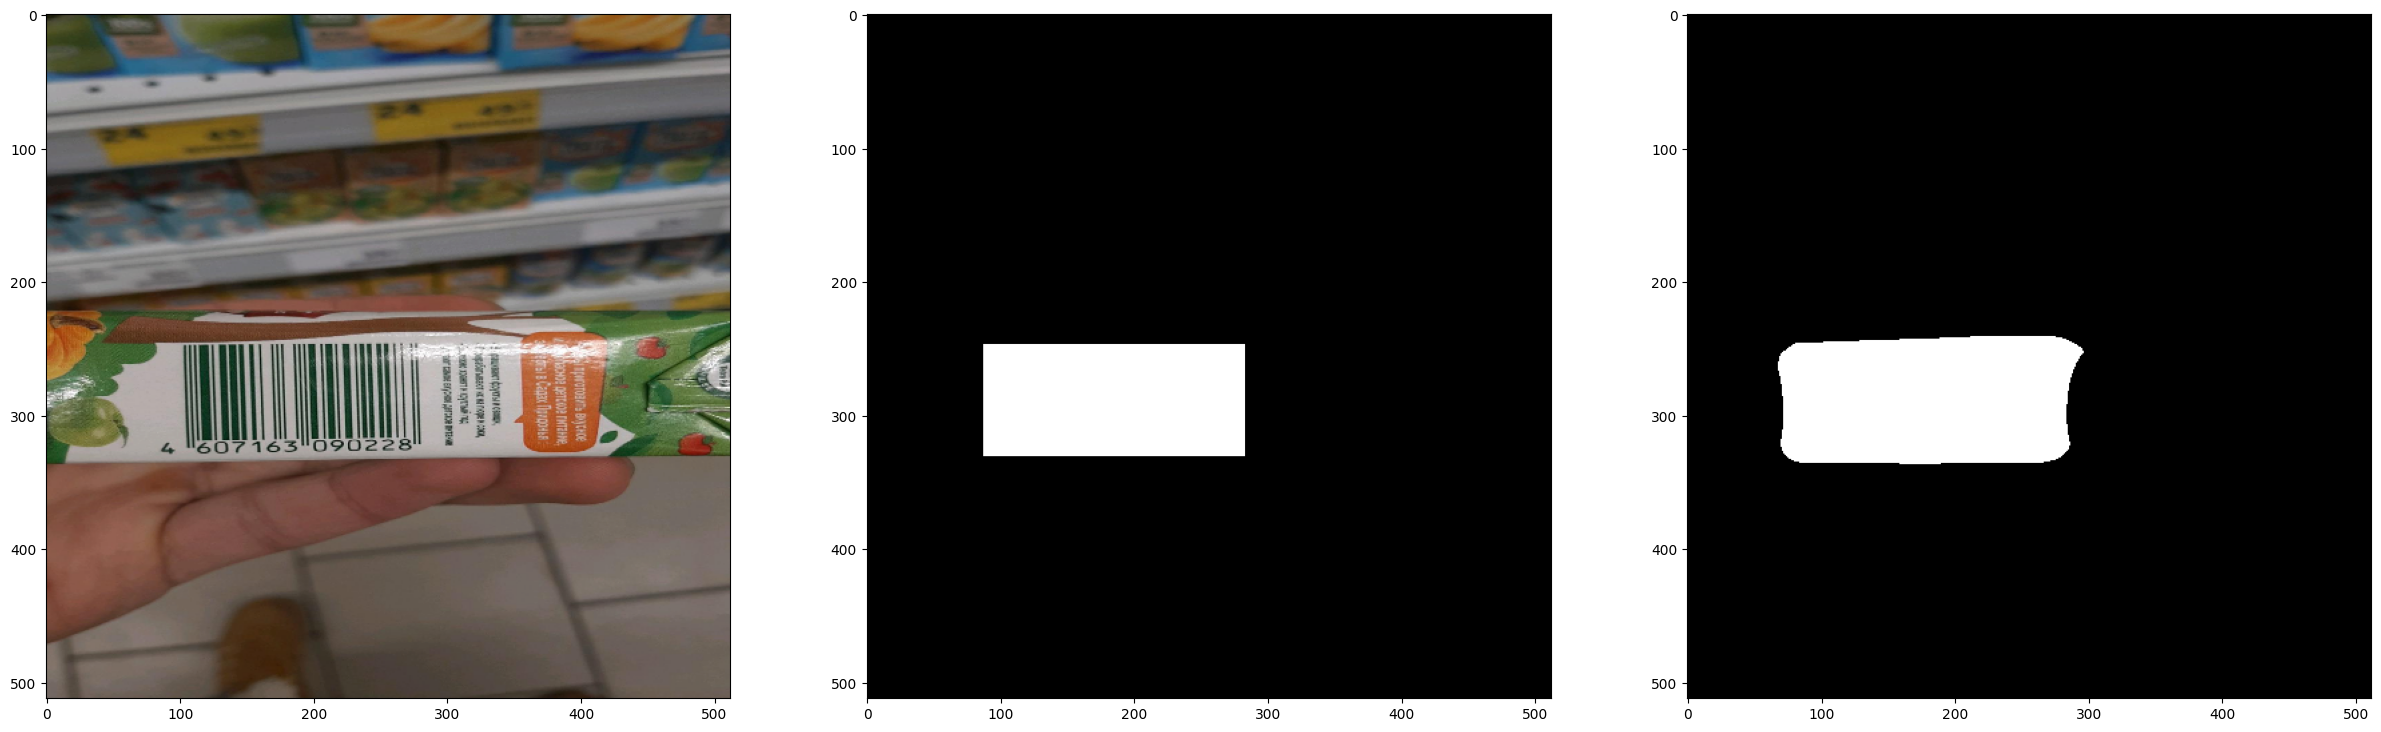

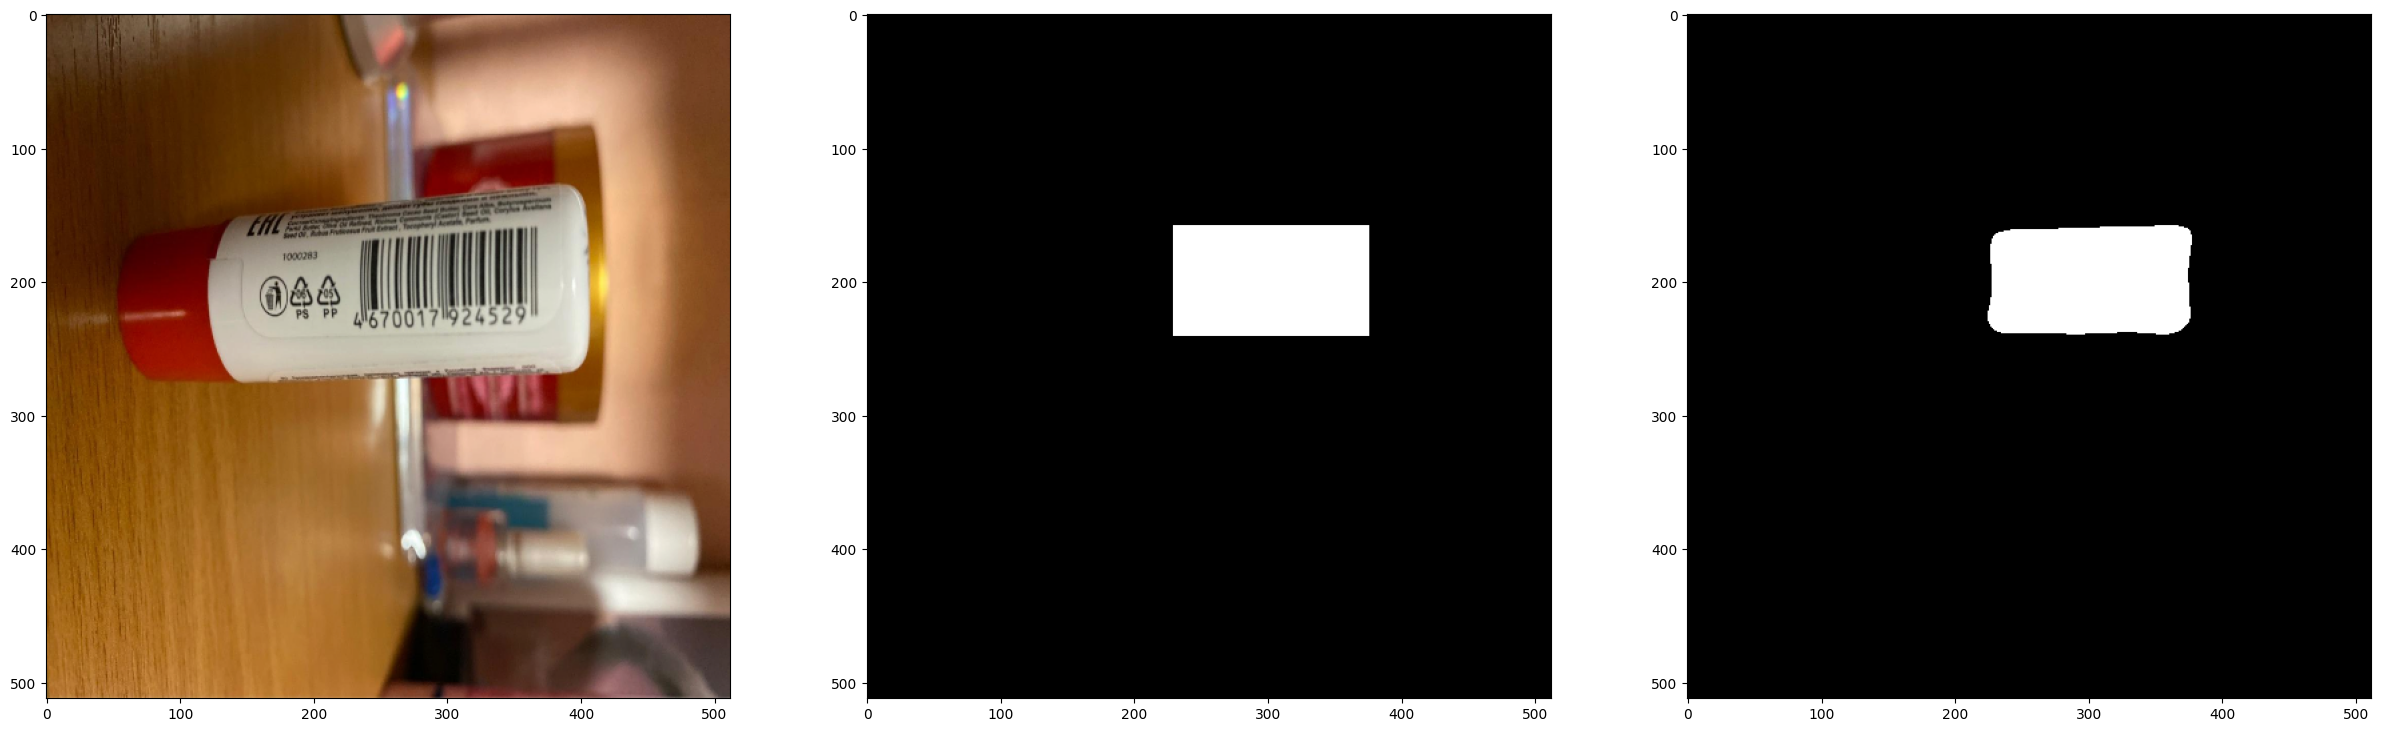

In [73]:
for i in range(5):
    random_i = np.random.choice(len(test_dataset))
    print(
        f"Selected index {random_i} from {test_dataset.__len__()}. Image: {test_dataset.image_paths[random_i]}"
    )
    image, gt_mask = test_dataset[random_i]
        
    test_image = np.transpose(image, (1,2,0))
    test_image = denormalize(test_image)
    test_image = test_image.astype(np.uint8)
    
    gt_mask = np.transpose(gt_mask, (1,2,0))
    
    pr_mask = best_model.predict(torch.from_numpy(image).to(DEVICE).unsqueeze(0))
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    plt.rcParams['figure.figsize'] = [30, 10]
    f, axarr = plt.subplots(1, 3) 
    
    axarr[0].imshow(test_image, cmap='gray', vmin=0, vmax=255)
    axarr[1].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
    axarr[2].imshow(pr_mask, cmap='gray', vmin=0, vmax=1)
    

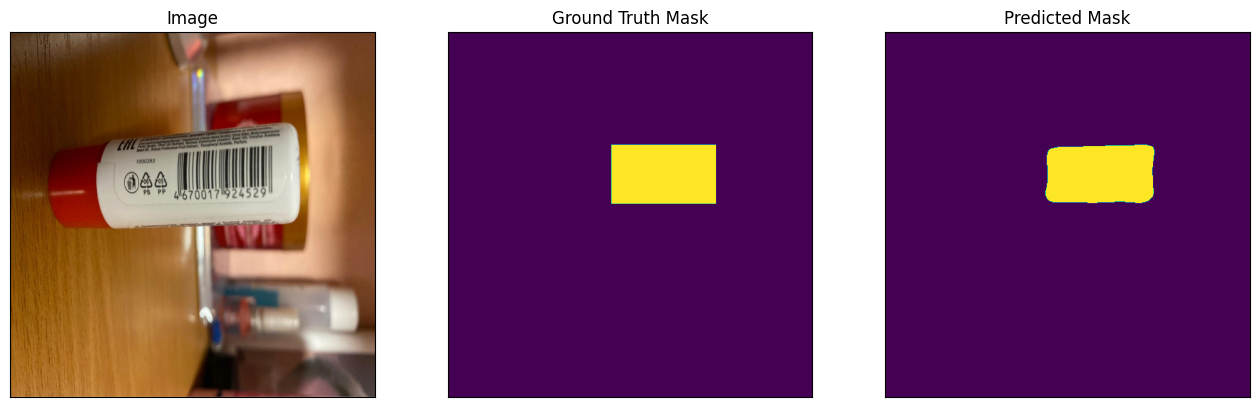

In [74]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
visualize(
        image=test_image, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )